In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values

In [5]:
training_set.shape

(1509, 1)

In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [7]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
X_train.shape

(1449, 60)

In [9]:
y_train.shape

(1449,)

In [10]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

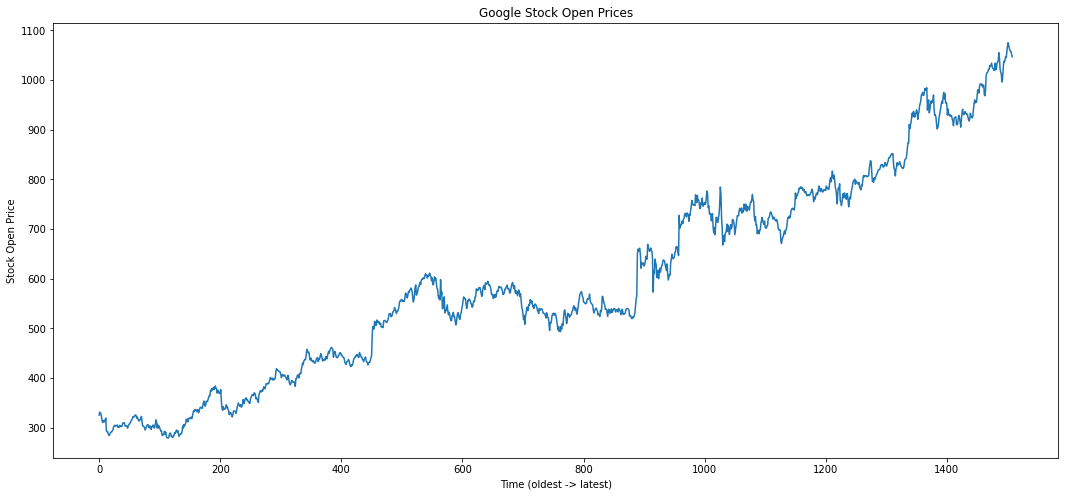

In [11]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

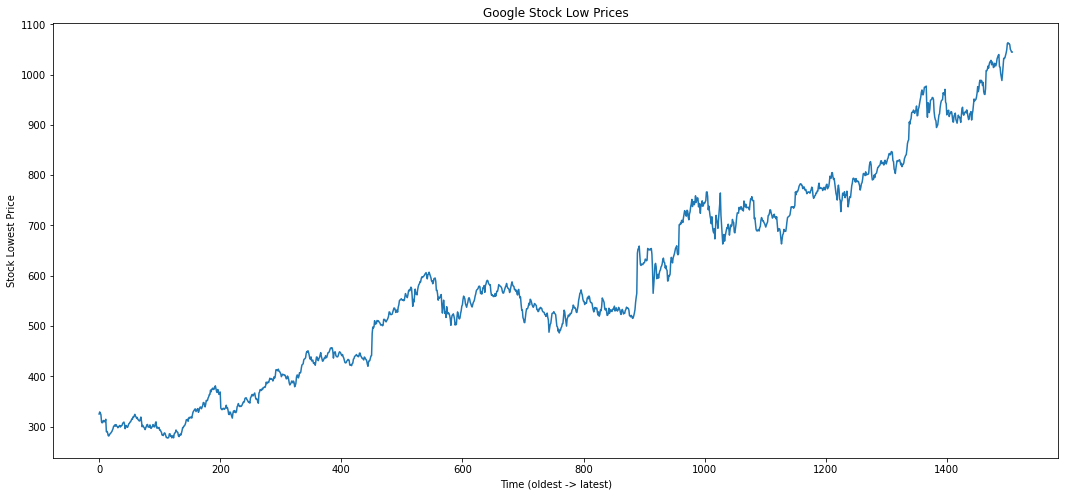

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Low'])
plt.title("Google Stock Low Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Lowest Price")
plt.show()

In [13]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [14]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [15]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
46/46 [==============================] - 18s 115ms/step - loss: 0.0238
Epoch 2/100
46/46 [==============================] - 5s 110ms/step - loss: 0.0039
Epoch 3/100
46/46 [==============================] - 5s 111ms/step - loss: 0.0030
Epoch 4/100
46/46 [==============================] - 5s 110ms/step - loss: 0.0039
Epoch 5/100
46/46 [==============================] - 5s 111ms/step - loss: 0.0034
Epoch 6/100
46/46 [==============================] - 5s 108ms/step - loss: 0.0030
Epoch 7/100
46/46 [==============================] - 5s 110ms/step - loss: 0.0032
Epoch 8/100
46/46 [==============================] - 5s 111ms/step - loss: 0.0028
Epoch 9/100
46/46 [==============================] - 5s 116ms/step - loss: 0.0028
Epoch 10/100
46/46 [==============================] - 6s 125ms/step - loss: 0.0027
Epoch 11/100
46/46 [==============================] - 5s 108ms/step - loss: 0.0025
Epoch 12/100
46/46 [==============================] - 5s 114ms/step - loss: 0.0025
Epoch 13/100

46/46 [==============================] - 5s 112ms/step - loss: 0.0011
Epoch 100/100
46/46 [==============================] - 5s 115ms/step - loss: 8.3789e-04


In [16]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [17]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,02/01/2018,1048.339966,1066.939941,1045.229980,1065.000000,1237600
1,03/01/2018,1064.310059,1086.290039,1063.209961,1082.479980,1430200
2,04/01/2018,1088.000000,1093.569946,1084.001953,1086.400024,1004600
3,05/01/2018,1094.000000,1104.250000,1092.000000,1102.229980,1279100
4,08/01/2018,1102.229980,1111.270020,1101.619995,1106.939941,1047600


In [18]:
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

(125, 1)

In [19]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [20]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)

In [21]:

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
predicted_stock_price = regressor.predict(X_test)

4/4 [==============================] - 3s 41ms/step


In [23]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

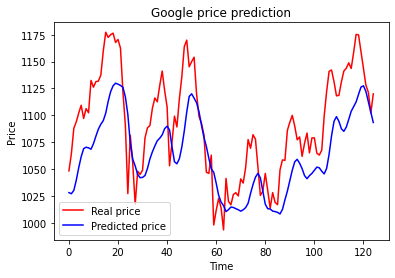

In [24]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()